
# Q-GAN

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [3]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    if done:
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current and next states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Previous and current actions given
    prev_actions = tf.placeholder(tf.int32, [None], name='prev_actions')
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Qs = qs+ (gamma * nextQs): targetQs is Qs and target_nextQs is nextQs
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    target_nextQs = tf.placeholder(tf.float32, [None], name='target_nextQs')
    
    # returning the given data to the model
    return prev_actions, states, actions, next_states, targetQs, target_nextQs

In [7]:
# Generator: Generating/predicting action and next states
def generator(prev_actions, states, action_size, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=(action_size + state_size))
        actions_logits, next_states_logits = tf.split(axis=1, num_or_size_splits=[action_size, state_size], 
                                                      value=logits)
        #predictions = tf.nn.softmax(actions_logits)
        #predictions = tf.sigmoid(next_states_logits)

        # return actions and states logits
        return actions_logits, next_states_logits

In [8]:
def discriminator(prev_actions, states, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        #print(x_fused.shape)
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        #print(h1.shape)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        #print(h2.shape)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)
        #predictions = tf.nn.softmax(logits)

        # return reward logits/Qs
        return logits

In [9]:
# The output of the generator
def model_output(prev_actions, states, 
                 actions, next_states, 
                 state_size, action_size, hidden_size):
    # Generator actions and next states
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, _ = generator(prev_actions=prev_actions_onehot, states=states,
                                  hidden_size=hidden_size, state_size=state_size, 
                                  action_size=action_size)
    
    # Generator for nextQs as targetQs
    actions_onehot = tf.one_hot(indices=actions, depth=action_size)
    next_actions_logits, _ = generator(prev_actions=actions_onehot, states=next_states,
                                       hidden_size=hidden_size, state_size=state_size, 
                                       action_size=action_size, reuse=True)
    
    # targetQs masking
    Qs_masked = tf.multiply(actions_logits, actions_onehot)
    Qs = tf.reduce_max(axis=1, input_tensor=Qs_masked)
    nextQs_unmasked = next_actions_logits
    
    # Returning nextQs unmasked to be masked and Qs to be used as targetQs and target_nextQs
    return actions_logits, Qs, nextQs_unmasked

In [10]:
# Calculating the loss of generator based on the generated/predicted states and actions
def model_loss(prev_actions, states, 
               actions, next_states, 
               targetQs, target_nextQs,
               state_size, action_size, hidden_size):
    # Generator actions and next states
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, next_states_logits = generator(prev_actions=prev_actions_onehot, states=states,
                                                   hidden_size=hidden_size, state_size=state_size, 
                                                   action_size=action_size, reuse=True)
    nextQs_fake_unmasked = discriminator(prev_actions=actions_logits, states=next_states_logits,
                                         hidden_size=hidden_size)
    
    # Discriminator for nextQs_real
    actions_onehot = tf.one_hot(indices=actions, depth=action_size)
    next_actions_logits, nextnext_states_logits = generator(prev_actions=actions_onehot, states=next_states,
                                                            hidden_size=hidden_size, state_size=state_size, 
                                                            action_size=action_size, reuse=True)
    nextnextQs_fake_unmasked = discriminator(prev_actions=next_actions_logits, states=nextnext_states_logits,
                                             hidden_size=hidden_size, reuse=True)
    
    # # Masking the unmasked nextQs using dones
    # dones_mask = tf.reshape(tensor=(1 - tf.cast(dtype=nextQs_fake_unmasked.dtype, x=dones)), shape=[-1, 1])
    # nextQs_fake_masked = tf.multiply(nextQs_fake_unmasked, dones_mask)
    # nextQs_real_masked = tf.multiply(nextQs_real_unmasked, dones_mask)
    # nextQs_fake = tf.reduce_max(axis=1, input_tensor=nextQs_fake_masked)
    # nextQs_real = tf.reduce_max(axis=1, input_tensor=nextQs_real_masked)
    #print(nextQs_fake_unmasked.shape, nextQs_real_unmasked.shape, targetQs.shape, target_nextQs.shape)
    targetQs = tf.reshape(targetQs, [-1, 1])
    target_nextQs = tf.reshape(target_nextQs, [-1, 1])
    
    # Adverserial learning/training
    g_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextnextQs_fake_unmasked, 
                                                                         labels=tf.sigmoid(targetQs)))
    g_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_fake_unmasked,
                                                                         labels=tf.sigmoid(target_nextQs)))
    # g_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_real_unmasked, 
    #                                                                      labels=tf.zeros_like(targetQs)))
    # g_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_fake_unmasked,
    #                                                                      labels=tf.sigmoid(targetQs)))
    # #g_loss_real = tf.reduce_mean(tf.square(nextQs_real - tf.zeros_like(targetQs)))
    # g_loss_real = tf.reduce_mean(tf.square(nextQs_real))
    # g_loss_fake = tf.reduce_mean(tf.square(nextQs_fake - targetQs))
    g_loss = g_loss_real + g_loss_fake

    # Adverserial learning/training
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextnextQs_fake_unmasked, 
                                                                         labels=tf.sigmoid(target_nextQs)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_fake_unmasked,
                                                                         labels=tf.sigmoid(targetQs)))
    # d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_real_unmasked, 
    #                                                                      labels=tf.sigmoid(targetQs)))
    # d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_fake_unmasked,
    #                                                                      labels=tf.zeros_like(targetQs)))
    # d_loss_real = tf.reduce_mean(tf.square(nextQs_real - targetQs))
    # #d_loss_fake = tf.reduce_mean(tf.square(nextQs_fake - tf.zeros_like(targetQs)))
    # d_loss_fake = tf.reduce_mean(tf.square(nextQs_fake))
    d_loss = d_loss_real + d_loss_fake
        
    # Returning the D loss
    return g_loss, d_loss

In [11]:
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss for next state and action prediction
    :param d_loss: Discriminator loss for reward prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Used for BN (batchnorm params)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars) # action prediction
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars) # reward prediction

    return g_opt, d_opt

In [12]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        ####################################### Model data inputs/outputs #######################################
        # Input of the Model: make the data available inside the framework
        self.prev_actions, self.states, self.actions, self.next_states, self.targetQs, self.target_nextQs = model_input(
            state_size=state_size)
        
        ######################################## Model losses #####################################################
        # Loss of the Model: action prediction/generation
        self.actions_logits, self.Qs, self.nextQs_unmasked = model_output(
            prev_actions=self.prev_actions, states=self.states,
            actions=self.actions, next_states=self.next_states, 
            state_size=state_size, action_size=action_size, hidden_size=hidden_size)
        
        # NOTE: Qs will be outputed and targetQs are the Qs used as labels
        self.g_loss, self.d_loss = model_loss(targetQs=self.targetQs, target_nextQs = self.target_nextQs,
                                              prev_actions=self.prev_actions, states=self.states, 
                                              actions=self.actions, next_states=self.next_states,
                                              state_size=state_size, action_size=action_size, 
                                              hidden_size=hidden_size)

        ######################################## Model updates #####################################################
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [15]:
# Training params
train_episodes = 2000          # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 2000               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [16]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [17]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
prev_action = env.action_space.sample() # At-1
state, _, done, _ = env.step(prev_action) # St, Rt/Et (Epiosde)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Make a random action
    action = env.action_space.sample()# At
    next_state, _, done, _ = env.step(action) #St+1

    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        prev_action = env.action_space.sample()
        state, _, done, _ = env.step(prev_action)
    else:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Prepare for the next round
        prev_action = action
        state = next_state

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [18]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
g_loss_list = []
d_loss_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    #train_episodes = 1 # for debugging
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        g_loss = 0
        d_loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.prev_actions: np.array([prev_action]), 
                             model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits) # arg with max value/Q is the class of action
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
    
            # Cumulative reward
            #total_reward += reward
            total_reward += 1 # done=False
            
            # Episode/epoch training is done/failed!
            if done is True:
                # the episode ends so no next state
                #next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, _, done, _ = env.step(prev_action)

            else:
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # One step forward: At-1=At and St=St+1
                prev_action = action
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            prev_actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            actions = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            
            # Calculating nextQs and setting them to 0 for states where episode ends/fails
            feed_dict={model.prev_actions: prev_actions, model.states: states, 
                       model.actions: actions, model.next_states: next_states}
            actions_logits, Qs, nextQs_unmasked = sess.run([model.actions_logits, 
                                                            model.Qs, 
                                                            model.nextQs_unmasked], feed_dict)
            # print('actions_logits, Qs, nextQs_unmasked:', 
            #       actions_logits.shape, Qs.shape, nextQs_unmasked.shape)

            # Masking for the end of episodes/ goals
            dones_mask = (1 - dones.astype(nextQs_unmasked.dtype)).reshape(-1, 1)
            nextQs_masked = np.multiply(nextQs_unmasked, dones_mask)
            nextQs = np.max(nextQs_masked, axis=1)
            # print('dones_mask.shape, nextQs_masked.shape, nextQs.shape:',
            # dones_mask.shape, nextQs_masked.shape, nextQs.shape)
            targetQs = Qs
            target_nextQs = nextQs#.reshape(-1, 1) # model loss calculation against logits
            #print(targetQs.shape)

            # Calculating nextQs for Discriminator using D(At-1, St)= Qt: NOT this one
            feed_dict = {model.prev_actions: prev_actions, 
                         model.states: states, 
                         model.actions: actions, 
                         model.next_states: next_states,
                         model.targetQs: targetQs,
                         model.target_nextQs: target_nextQs}
            # g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            # d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            g_loss, _, d_loss, _ = sess.run([model.g_loss,
                                             model.g_opt,
                                             model.d_loss, 
                                             model.d_opt], feed_dict)
                        
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 24 Training g_loss: 1.3794 Training d_loss: 1.3794 Explore P: 0.9976
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 19 Training g_loss: 1.3795 Training d_loss: 1.3793 Explore P: 0.9958
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 31 Training g_loss: 1.3761 Training d_loss: 1.3759 Explore P: 0.9927
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 13 Training g_loss: 1.3751 Training d_loss: 1.3749 Explore P: 0.9914
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 33 Total reward: 30 Training g_loss: 1.3842 Training d_loss: 1.3842 Explore P: 0.9333
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 34 Total reward: 23 Training g_loss: 1.3840 Training d_loss: 1.3841 Explore P: 0.9312
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 35 Total reward: 17 Training g_loss: 1.3846 Training d_loss: 1.3846 Explore P: 0.9297
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 36 Total reward: 39 Training g_loss: 1.3846 Training d_loss: 1.3846 Explore P: 0.9261
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 66 Total reward: 19 Training g_loss: 1.3856 Training d_loss: 1.3856 Explore P: 0.8653
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 67 Total reward: 12 Training g_loss: 1.3856 Training d_loss: 1.3856 Explore P: 0.8642
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 68 Total reward: 19 Training g_loss: 1.3856 Training d_loss: 1.3856 Explore P: 0.8626
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 69 Total reward: 33 Training g_loss: 1.3857 Training d_loss: 1.3857 Explore P: 0.8598
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 99 Total reward: 20 Training g_loss: 1.3860 Training d_loss: 1.3860 Explore P: 0.8113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 100 Total reward: 19 Training g_loss: 1.3859 Training d_loss: 1.3859 Explore P: 0.8098
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 101 Total reward: 18 Training g_loss: 1.3858 Training d_loss: 1.3859 Explore P: 0.8083
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 102 Total reward: 24 Training g_loss: 1.3858 Training d_loss: 1.3858 Explore P: 0.8064
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 132 Total reward: 22 Training g_loss: 1.3860 Training d_loss: 1.3859 Explore P: 0.7600
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 133 Total reward: 14 Training g_loss: 1.3860 Training d_loss: 1.3860 Explore P: 0.7590
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 134 Total reward: 11 Training g_loss: 1.3860 Training d_loss: 1.3860 Explore P: 0.7582
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 135 Total reward: 12 Training g_loss: 1.3861 Training d_loss: 1.3861 Explore P: 0.7573
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 165 Total reward: 33 Training g_loss: 1.3861 Training d_loss: 1.3861 Explore P: 0.7119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 166 Total reward: 33 Training g_loss: 1.3859 Training d_loss: 1.3859 Explore P: 0.7096
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 167 Total reward: 19 Training g_loss: 1.3861 Training d_loss: 1.3861 Explore P: 0.7083
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 168 Total reward: 27 Training g_loss: 1.3860 Training d_loss: 1.3860 Explore P: 0.7064
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 199 Total reward: 10 Training g_loss: 1.3680 Training d_loss: 1.3686 Explore P: 0.6728
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 200 Total reward: 13 Training g_loss: 1.3822 Training d_loss: 1.3820 Explore P: 0.6720
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 201 Total reward: 10 Training g_loss: 1.3841 Training d_loss: 1.3841 Explore P: 0.6713
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 202 Total reward: 8 Training g_loss: 1.3820 Training d_loss: 1.3819 Explore P: 0.6708
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 232 Total reward: 14 Training g_loss: 1.3844 Training d_loss: 1.3843 Explore P: 0.6336
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 233 Total reward: 12 Training g_loss: 1.3837 Training d_loss: 1.3837 Explore P: 0.6328
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 234 Total reward: 9 Training g_loss: 1.3839 Training d_loss: 1.3840 Explore P: 0.6323
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 235 Total reward: 19 Training g_loss: 1.3838 Training d_loss: 1.3838 Explore P: 0.6311
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 265 Total reward: 14 Training g_loss: 1.3824 Training d_loss: 1.3822 Explore P: 0.6003
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 266 Total reward: 9 Training g_loss: 1.3821 Training d_loss: 1.3821 Explore P: 0.5998
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 267 Total reward: 14 Training g_loss: 1.3821 Training d_loss: 1.3822 Explore P: 0.5990
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 268 Total reward: 8 Training g_loss: 1.3801 Training d_loss: 1.3799 Explore P: 0.5985
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 298 Total reward: 12 Training g_loss: 1.3843 Training d_loss: 1.3843 Explore P: 0.5757
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 299 Total reward: 17 Training g_loss: 1.3840 Training d_loss: 1.3840 Explore P: 0.5747
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 300 Total reward: 13 Training g_loss: 1.3832 Training d_loss: 1.3831 Explore P: 0.5740
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 301 Total reward: 10 Training g_loss: 1.3826 Training d_loss: 1.3826 Explore P: 0.5734
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 331 Total reward: 19 Training g_loss: 1.3525 Training d_loss: 1.3553 Explore P: 0.5488
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 332 Total reward: 12 Training g_loss: 1.3502 Training d_loss: 1.3501 Explore P: 0.5481
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 333 Total reward: 26 Training g_loss: 1.3849 Training d_loss: 1.3847 Explore P: 0.5467
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 334 Total reward: 16 Training g_loss: 1.3846 Training d_loss: 1.3845 Explore P: 0.5459
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 364 Total reward: 22 Training g_loss: 1.3746 Training d_loss: 1.3753 Explore P: 0.5206
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 365 Total reward: 12 Training g_loss: 1.3715 Training d_loss: 1.3726 Explore P: 0.5200
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 366 Total reward: 15 Training g_loss: 1.3673 Training d_loss: 1.3684 Explore P: 0.5192
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 367 Total reward: 8 Training g_loss: 1.3660 Training d_loss: 1.3666 Explore P: 0.5188
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 397 Total reward: 18 Training g_loss: 1.3822 Training d_loss: 1.3818 Explore P: 0.4999
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 398 Total reward: 17 Training g_loss: 1.3823 Training d_loss: 1.3821 Explore P: 0.4991
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 399 Total reward: 8 Training g_loss: 1.3815 Training d_loss: 1.3815 Explore P: 0.4987
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 400 Total reward: 8 Training g_loss: 1.3803 Training d_loss: 1.3804 Explore P: 0.4983
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 431 Total reward: 14 Training g_loss: 1.3676 Training d_loss: 1.3668 Explore P: 0.4769
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 432 Total reward: 14 Training g_loss: 1.3800 Training d_loss: 1.3791 Explore P: 0.4762
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 433 Total reward: 11 Training g_loss: 1.3835 Training d_loss: 1.3834 Explore P: 0.4757
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 434 Total reward: 14 Training g_loss: 1.3807 Training d_loss: 1.3809 Explore P: 0.4751
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 465 Total reward: 13 Training g_loss: 1.3837 Training d_loss: 1.3837 Explore P: 0.4542
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 466 Total reward: 23 Training g_loss: 1.3837 Training d_loss: 1.3836 Explore P: 0.4531
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 467 Total reward: 13 Training g_loss: 1.3835 Training d_loss: 1.3834 Explore P: 0.4526
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 468 Total reward: 10 Training g_loss: 1.3836 Training d_loss: 1.3835 Explore P: 0.4521
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 498 Total reward: 26 Training g_loss: 1.3805 Training d_loss: 1.3793 Explore P: 0.4348
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 499 Total reward: 9 Training g_loss: 1.3760 Training d_loss: 1.3749 Explore P: 0.4345
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 500 Total reward: 12 Training g_loss: 1.3659 Training d_loss: 1.3643 Explore P: 0.4339
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 501 Total reward: 11 Training g_loss: 1.3617 Training d_loss: 1.3610 Explore P: 0.4335
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 532 Total reward: 15 Training g_loss: 1.3776 Training d_loss: 1.3776 Explore P: 0.4170
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 533 Total reward: 18 Training g_loss: 1.3729 Training d_loss: 1.3738 Explore P: 0.4162
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 534 Total reward: 7 Training g_loss: 1.3695 Training d_loss: 1.3698 Explore P: 0.4159
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 535 Total reward: 12 Training g_loss: 1.3683 Training d_loss: 1.3679 Explore P: 0.4155
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 565 Total reward: 10 Training g_loss: 1.3809 Training d_loss: 1.3806 Explore P: 0.4002
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 566 Total reward: 12 Training g_loss: 1.3819 Training d_loss: 1.3815 Explore P: 0.3997
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 567 Total reward: 9 Training g_loss: 1.3836 Training d_loss: 1.3833 Explore P: 0.3994
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 568 Total reward: 12 Training g_loss: 1.3846 Training d_loss: 1.3844 Explore P: 0.3989
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 599 Total reward: 22 Training g_loss: 1.3819 Training d_loss: 1.3819 Explore P: 0.3849
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 600 Total reward: 11 Training g_loss: 1.3816 Training d_loss: 1.3818 Explore P: 0.3845
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 601 Total reward: 8 Training g_loss: 1.3810 Training d_loss: 1.3811 Explore P: 0.3842
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 602 Total reward: 17 Training g_loss: 1.3795 Training d_loss: 1.3796 Explore P: 0.3836
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 632 Total reward: 8 Training g_loss: 1.3838 Training d_loss: 1.3839 Explore P: 0.3706
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 633 Total reward: 14 Training g_loss: 1.3824 Training d_loss: 1.3826 Explore P: 0.3701
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 634 Total reward: 11 Training g_loss: 1.3832 Training d_loss: 1.3835 Explore P: 0.3697
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 635 Total reward: 16 Training g_loss: 1.3834 Training d_loss: 1.3836 Explore P: 0.3692
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 665 Total reward: 25 Training g_loss: 1.3814 Training d_loss: 1.3816 Explore P: 0.3550
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 666 Total reward: 17 Training g_loss: 1.3739 Training d_loss: 1.3746 Explore P: 0.3544
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 667 Total reward: 18 Training g_loss: 1.3564 Training d_loss: 1.3581 Explore P: 0.3537
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 668 Total reward: 11 Training g_loss: 1.3488 Training d_loss: 1.3465 Explore P: 0.3534
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 698 Total reward: 8 Training g_loss: 1.3788 Training d_loss: 1.3789 Explore P: 0.3416
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 699 Total reward: 10 Training g_loss: 1.3777 Training d_loss: 1.3774 Explore P: 0.3413
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 700 Total reward: 10 Training g_loss: 1.3787 Training d_loss: 1.3786 Explore P: 0.3410
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 701 Total reward: 13 Training g_loss: 1.3785 Training d_loss: 1.3783 Explore P: 0.3405
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 731 Total reward: 13 Training g_loss: 1.3818 Training d_loss: 1.3818 Explore P: 0.3303
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 732 Total reward: 12 Training g_loss: 1.3815 Training d_loss: 1.3815 Explore P: 0.3299
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 733 Total reward: 12 Training g_loss: 1.3818 Training d_loss: 1.3818 Explore P: 0.3295
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 734 Total reward: 9 Training g_loss: 1.3814 Training d_loss: 1.3815 Explore P: 0.3293
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 764 Total reward: 10 Training g_loss: 1.3828 Training d_loss: 1.3827 Explore P: 0.3192
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 765 Total reward: 10 Training g_loss: 1.3829 Training d_loss: 1.3830 Explore P: 0.3189
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 766 Total reward: 10 Training g_loss: 1.3832 Training d_loss: 1.3832 Explore P: 0.3186
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 767 Total reward: 8 Training g_loss: 1.3828 Training d_loss: 1.3829 Explore P: 0.3183
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 797 Total reward: 8 Training g_loss: 1.3831 Training d_loss: 1.3830 Explore P: 0.3082
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 798 Total reward: 7 Training g_loss: 1.3834 Training d_loss: 1.3833 Explore P: 0.3080
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 799 Total reward: 9 Training g_loss: 1.3840 Training d_loss: 1.3838 Explore P: 0.3077
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 800 Total reward: 14 Training g_loss: 1.3840 Training d_loss: 1.3840 Explore P: 0.3073
-----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 830 Total reward: 15 Training g_loss: 1.3849 Training d_loss: 1.3849 Explore P: 0.2981
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 831 Total reward: 10 Training g_loss: 1.3851 Training d_loss: 1.3850 Explore P: 0.2978
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 832 Total reward: 10 Training g_loss: 1.3851 Training d_loss: 1.3850 Explore P: 0.2976
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 833 Total reward: 11 Training g_loss: 1.3849 Training d_loss: 1.3849 Explore P: 0.2972
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 864 Total reward: 10 Training g_loss: 1.3856 Training d_loss: 1.3856 Explore P: 0.2875
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 865 Total reward: 10 Training g_loss: 1.3858 Training d_loss: 1.3857 Explore P: 0.2872
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 866 Total reward: 9 Training g_loss: 1.3858 Training d_loss: 1.3857 Explore P: 0.2869
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 867 Total reward: 16 Training g_loss: 1.3857 Training d_loss: 1.3857 Explore P: 0.2865
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 897 Total reward: 21 Training g_loss: 1.3858 Training d_loss: 1.3857 Explore P: 0.2774
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 898 Total reward: 11 Training g_loss: 1.3858 Training d_loss: 1.3858 Explore P: 0.2771
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 899 Total reward: 10 Training g_loss: 1.3858 Training d_loss: 1.3858 Explore P: 0.2768
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 900 Total reward: 10 Training g_loss: 1.3857 Training d_loss: 1.3857 Explore P: 0.2766
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 931 Total reward: 12 Training g_loss: 1.3847 Training d_loss: 1.3848 Explore P: 0.2681
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 932 Total reward: 8 Training g_loss: 1.3844 Training d_loss: 1.3845 Explore P: 0.2679
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 933 Total reward: 14 Training g_loss: 1.3848 Training d_loss: 1.3847 Explore P: 0.2675
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 934 Total reward: 12 Training g_loss: 1.3849 Training d_loss: 1.3849 Explore P: 0.2672
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 964 Total reward: 8 Training g_loss: 1.3842 Training d_loss: 1.3841 Explore P: 0.2595
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 965 Total reward: 8 Training g_loss: 1.3846 Training d_loss: 1.3847 Explore P: 0.2593
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 966 Total reward: 8 Training g_loss: 1.3845 Training d_loss: 1.3845 Explore P: 0.2591
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 967 Total reward: 11 Training g_loss: 1.3841 Training d_loss: 1.3840 Explore P: 0.2588
-----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 998 Total reward: 10 Training g_loss: 1.3858 Training d_loss: 1.3857 Explore P: 0.2502
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 999 Total reward: 7 Training g_loss: 1.3858 Training d_loss: 1.3857 Explore P: 0.2500
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1000 Total reward: 9 Training g_loss: 1.3858 Training d_loss: 1.3858 Explore P: 0.2498
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1001 Total reward: 10 Training g_loss: 1.3859 Training d_loss: 1.3859 Explore P: 0.2496
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1030 Total reward: 14 Training g_loss: 1.3860 Training d_loss: 1.3860 Explore P: 0.2418
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1031 Total reward: 8 Training g_loss: 1.3860 Training d_loss: 1.3860 Explore P: 0.2416
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1032 Total reward: 9 Training g_loss: 1.3860 Training d_loss: 1.3860 Explore P: 0.2414
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1033 Total reward: 13 Training g_loss: 1.3860 Training d_loss: 1.3859 Explore P: 0.2411
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1062 Total reward: 11 Training g_loss: 1.3862 Training d_loss: 1.3861 Explore P: 0.2338
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1063 Total reward: 14 Training g_loss: 1.3859 Training d_loss: 1.3858 Explore P: 0.2335
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1064 Total reward: 10 Training g_loss: 1.3859 Training d_loss: 1.3859 Explore P: 0.2333
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1065 Total reward: 14 Training g_loss: 1.3861 Training d_loss: 1.3861 Explore P: 0.2329
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1094 Total reward: 8 Training g_loss: 1.3856 Training d_loss: 1.3855 Explore P: 0.2262
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1095 Total reward: 8 Training g_loss: 1.3856 Training d_loss: 1.3855 Explore P: 0.2260
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1096 Total reward: 16 Training g_loss: 1.3854 Training d_loss: 1.3854 Explore P: 0.2257
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1097 Total reward: 12 Training g_loss: 1.3853 Training d_loss: 1.3853 Explore P: 0.2254
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1126 Total reward: 12 Training g_loss: 1.3844 Training d_loss: 1.3842 Explore P: 0.2196
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1127 Total reward: 11 Training g_loss: 1.3855 Training d_loss: 1.3853 Explore P: 0.2194
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1128 Total reward: 11 Training g_loss: 1.3829 Training d_loss: 1.3825 Explore P: 0.2191
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1129 Total reward: 9 Training g_loss: 1.3781 Training d_loss: 1.3779 Explore P: 0.2190
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1159 Total reward: 11 Training g_loss: 1.2400 Training d_loss: 1.2310 Explore P: 0.2125
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1160 Total reward: 10 Training g_loss: 1.2417 Training d_loss: 1.2375 Explore P: 0.2123
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1161 Total reward: 26 Training g_loss: 1.2416 Training d_loss: 1.2367 Explore P: 0.2117
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1162 Total reward: 8 Training g_loss: 1.2169 Training d_loss: 1.2134 Explore P: 0.2116
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1191 Total reward: 14 Training g_loss: 0.3728 Training d_loss: 0.3797 Explore P: 0.2055
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1192 Total reward: 11 Training g_loss: 0.3493 Training d_loss: 0.3558 Explore P: 0.2052
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1193 Total reward: 10 Training g_loss: 0.3473 Training d_loss: 0.3493 Explore P: 0.2050
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1194 Total reward: 8 Training g_loss: 0.3252 Training d_loss: 0.3289 Explore P: 0.2049
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1223 Total reward: 14 Training g_loss: 0.4145 Training d_loss: 0.3965 Explore P: 0.1985
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1224 Total reward: 11 Training g_loss: 0.4102 Training d_loss: 0.3912 Explore P: 0.1983
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1225 Total reward: 11 Training g_loss: 0.4000 Training d_loss: 0.3899 Explore P: 0.1981
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1226 Total reward: 9 Training g_loss: 0.4233 Training d_loss: 0.4216 Explore P: 0.1979
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1255 Total reward: 10 Training g_loss: 1.0150 Training d_loss: 1.0185 Explore P: 0.1886
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1256 Total reward: 28 Training g_loss: 1.1021 Training d_loss: 1.1003 Explore P: 0.1881
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1257 Total reward: 39 Training g_loss: 1.1878 Training d_loss: 1.1879 Explore P: 0.1874
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1258 Total reward: 10 Training g_loss: 1.1854 Training d_loss: 1.1860 Explore P: 0.1872
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1287 Total reward: 12 Training g_loss: 1.1577 Training d_loss: 1.1579 Explore P: 0.1802
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1288 Total reward: 9 Training g_loss: 1.1577 Training d_loss: 1.1541 Explore P: 0.1801
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1289 Total reward: 14 Training g_loss: 1.1835 Training d_loss: 1.1806 Explore P: 0.1798
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1290 Total reward: 9 Training g_loss: 1.1919 Training d_loss: 1.1913 Explore P: 0.1797
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1319 Total reward: 10 Training g_loss: 1.0643 Training d_loss: 1.0637 Explore P: 0.1743
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1320 Total reward: 11 Training g_loss: 0.9304 Training d_loss: 0.9302 Explore P: 0.1741
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1321 Total reward: 10 Training g_loss: 0.8859 Training d_loss: 0.8863 Explore P: 0.1740
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1322 Total reward: 9 Training g_loss: 0.8250 Training d_loss: 0.8202 Explore P: 0.1738
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1351 Total reward: 9 Training g_loss: 1.0565 Training d_loss: 1.0569 Explore P: 0.1688
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1352 Total reward: 10 Training g_loss: 1.0387 Training d_loss: 1.0380 Explore P: 0.1687
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1353 Total reward: 9 Training g_loss: 0.9754 Training d_loss: 0.9742 Explore P: 0.1685
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1354 Total reward: 12 Training g_loss: 0.8899 Training d_loss: 0.8895 Explore P: 0.1683
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1384 Total reward: 18 Training g_loss: 1.2729 Training d_loss: 1.2671 Explore P: 0.1606
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1385 Total reward: 7 Training g_loss: 1.2275 Training d_loss: 1.2244 Explore P: 0.1604
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1386 Total reward: 11 Training g_loss: 1.2207 Training d_loss: 1.2203 Explore P: 0.1603
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1387 Total reward: 24 Training g_loss: 1.1433 Training d_loss: 1.1420 Explore P: 0.1599
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1416 Total reward: 13 Training g_loss: 0.7297 Training d_loss: 0.7321 Explore P: 0.1527
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1417 Total reward: 8 Training g_loss: 0.7678 Training d_loss: 0.7794 Explore P: 0.1526
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1418 Total reward: 8 Training g_loss: 0.9301 Training d_loss: 0.9297 Explore P: 0.1525
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1419 Total reward: 11 Training g_loss: 1.1400 Training d_loss: 1.1199 Explore P: 0.1523
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1448 Total reward: 10 Training g_loss: 0.8773 Training d_loss: 0.8995 Explore P: 0.1474
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1449 Total reward: 17 Training g_loss: 0.8744 Training d_loss: 0.9060 Explore P: 0.1472
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1450 Total reward: 15 Training g_loss: 0.9808 Training d_loss: 0.9718 Explore P: 0.1470
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1451 Total reward: 11 Training g_loss: 1.0176 Training d_loss: 1.0029 Explore P: 0.1468
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1480 Total reward: 10 Training g_loss: 1.2202 Training d_loss: 1.2237 Explore P: 0.1428
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1481 Total reward: 12 Training g_loss: 1.2252 Training d_loss: 1.2369 Explore P: 0.1426
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1482 Total reward: 9 Training g_loss: 1.2069 Training d_loss: 1.2205 Explore P: 0.1425
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1483 Total reward: 8 Training g_loss: 1.2210 Training d_loss: 1.2283 Explore P: 0.1424
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1512 Total reward: 116 Training g_loss: 0.1158 Training d_loss: 0.1140 Explore P: 0.1265
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1513 Total reward: 86 Training g_loss: 0.1287 Training d_loss: 0.1275 Explore P: 0.1255
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1514 Total reward: 61 Training g_loss: 0.1505 Training d_loss: 0.1441 Explore P: 0.1248
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1515 Total reward: 58 Training g_loss: 0.1224 Training d_loss: 0.1177 Explore P: 0.1241
---------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1544 Total reward: 9 Training g_loss: 0.1395 Training d_loss: 0.1248 Explore P: 0.1202
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1545 Total reward: 13 Training g_loss: 0.1473 Training d_loss: 0.1483 Explore P: 0.1200
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1546 Total reward: 8 Training g_loss: 0.1164 Training d_loss: 0.1167 Explore P: 0.1199
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1547 Total reward: 19 Training g_loss: 0.1508 Training d_loss: 0.1494 Explore P: 0.1197
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1577 Total reward: 9 Training g_loss: 0.1474 Training d_loss: 0.1382 Explore P: 0.1148
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1578 Total reward: 10 Training g_loss: 0.1191 Training d_loss: 0.1180 Explore P: 0.1146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1579 Total reward: 9 Training g_loss: 0.1291 Training d_loss: 0.1265 Explore P: 0.1146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1580 Total reward: 9 Training g_loss: 0.1394 Training d_loss: 0.1405 Explore P: 0.1145
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1609 Total reward: 10 Training g_loss: 0.1227 Training d_loss: 0.1243 Explore P: 0.1114
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1610 Total reward: 11 Training g_loss: 0.1215 Training d_loss: 0.1219 Explore P: 0.1113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1611 Total reward: 9 Training g_loss: 0.1390 Training d_loss: 0.1363 Explore P: 0.1112
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1612 Total reward: 12 Training g_loss: 0.1374 Training d_loss: 0.1340 Explore P: 0.1111
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1642 Total reward: 14 Training g_loss: 0.1280 Training d_loss: 0.1302 Explore P: 0.1080
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1643 Total reward: 12 Training g_loss: 0.1350 Training d_loss: 0.1306 Explore P: 0.1079
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1644 Total reward: 11 Training g_loss: 0.1192 Training d_loss: 0.1206 Explore P: 0.1078
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1645 Total reward: 8 Training g_loss: 0.1344 Training d_loss: 0.1307 Explore P: 0.1077
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1674 Total reward: 11 Training g_loss: 0.1327 Training d_loss: 0.1327 Explore P: 0.1049
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1675 Total reward: 11 Training g_loss: 0.1316 Training d_loss: 0.1292 Explore P: 0.1048
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1676 Total reward: 9 Training g_loss: 0.1336 Training d_loss: 0.1299 Explore P: 0.1047
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1677 Total reward: 8 Training g_loss: 0.1374 Training d_loss: 0.1380 Explore P: 0.1047
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1706 Total reward: 8 Training g_loss: 0.1215 Training d_loss: 0.1214 Explore P: 0.1020
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1707 Total reward: 8 Training g_loss: 0.1273 Training d_loss: 0.1232 Explore P: 0.1019
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1708 Total reward: 7 Training g_loss: 0.1376 Training d_loss: 0.1323 Explore P: 0.1018
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1709 Total reward: 10 Training g_loss: 0.1143 Training d_loss: 0.1146 Explore P: 0.1017
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1738 Total reward: 13 Training g_loss: 0.1333 Training d_loss: 0.1347 Explore P: 0.0990
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1739 Total reward: 9 Training g_loss: 0.1375 Training d_loss: 0.1392 Explore P: 0.0989
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1740 Total reward: 12 Training g_loss: 0.1336 Training d_loss: 0.1366 Explore P: 0.0988
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1741 Total reward: 9 Training g_loss: 0.1333 Training d_loss: 0.1323 Explore P: 0.0987
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1771 Total reward: 12 Training g_loss: 0.1319 Training d_loss: 0.1251 Explore P: 0.0900
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1772 Total reward: 15 Training g_loss: 0.1301 Training d_loss: 0.1227 Explore P: 0.0899
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1773 Total reward: 10 Training g_loss: 0.1263 Training d_loss: 0.1188 Explore P: 0.0898
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1774 Total reward: 9 Training g_loss: 0.1490 Training d_loss: 0.1387 Explore P: 0.0897
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1803 Total reward: 14 Training g_loss: 0.1841 Training d_loss: 0.1872 Explore P: 0.0869
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1804 Total reward: 18 Training g_loss: 0.1616 Training d_loss: 0.1556 Explore P: 0.0868
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1805 Total reward: 10 Training g_loss: 0.1762 Training d_loss: 0.1742 Explore P: 0.0867
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1806 Total reward: 16 Training g_loss: 0.1723 Training d_loss: 0.1738 Explore P: 0.0866
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1835 Total reward: 19 Training g_loss: 0.1445 Training d_loss: 0.1394 Explore P: 0.0833
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1836 Total reward: 12 Training g_loss: 0.1496 Training d_loss: 0.1437 Explore P: 0.0832
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1837 Total reward: 34 Training g_loss: 0.1386 Training d_loss: 0.1356 Explore P: 0.0830
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1838 Total reward: 15 Training g_loss: 0.1390 Training d_loss: 0.1421 Explore P: 0.0829
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1868 Total reward: 22 Training g_loss: 0.1552 Training d_loss: 0.1612 Explore P: 0.0803
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1869 Total reward: 10 Training g_loss: 0.1692 Training d_loss: 0.1738 Explore P: 0.0803
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1870 Total reward: 10 Training g_loss: 0.1663 Training d_loss: 0.1751 Explore P: 0.0802
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1871 Total reward: 26 Training g_loss: 0.2018 Training d_loss: 0.2058 Explore P: 0.0800
----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1900 Total reward: 11 Training g_loss: 0.1985 Training d_loss: 0.2059 Explore P: 0.0778
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1901 Total reward: 15 Training g_loss: 0.1841 Training d_loss: 0.1905 Explore P: 0.0777
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1902 Total reward: 13 Training g_loss: 0.1909 Training d_loss: 0.1983 Explore P: 0.0776
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1903 Total reward: 8 Training g_loss: 0.1969 Training d_loss: 0.2026 Explore P: 0.0775
-----------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1932 Total reward: 8 Training g_loss: 0.1643 Training d_loss: 0.1664 Explore P: 0.0754
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1933 Total reward: 8 Training g_loss: 0.1508 Training d_loss: 0.1541 Explore P: 0.0753
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1934 Total reward: 16 Training g_loss: 0.1430 Training d_loss: 0.1497 Explore P: 0.0752
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1935 Total reward: 8 Training g_loss: 0.1501 Training d_loss: 0.1547 Explore P: 0.0752
-------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1965 Total reward: 10 Training g_loss: 0.1329 Training d_loss: 0.1290 Explore P: 0.0731
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1966 Total reward: 7 Training g_loss: 0.1428 Training d_loss: 0.1399 Explore P: 0.0731
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1967 Total reward: 8 Training g_loss: 0.1446 Training d_loss: 0.1420 Explore P: 0.0730
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1968 Total reward: 11 Training g_loss: 0.1384 Training d_loss: 0.1358 Explore P: 0.0729
------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 1998 Total reward: 8 Training g_loss: 0.1458 Training d_loss: 0.1489 Explore P: 0.0709
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1999 Total reward: 11 Training g_loss: 0.1644 Training d_loss: 0.1587 Explore P: 0.0708
-------------------------------------------------------------------------------


## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

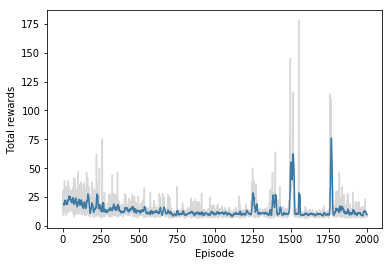

In [24]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

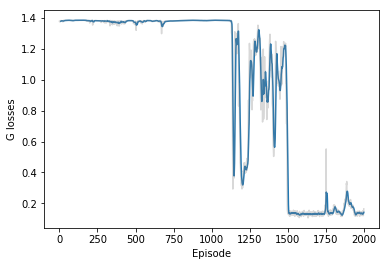

In [25]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

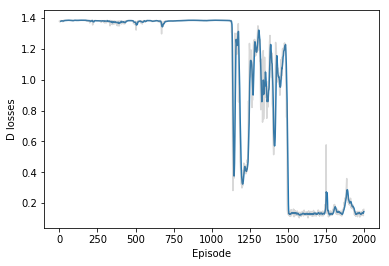

In [26]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [43]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# # env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
# env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from the model
            feed_dict = {model.prev_actions: np.array([prev_action]), 
                         model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, reward, done, _ = env.step(prev_action)
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [45]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.